In [2]:
from pathlib import Path
import sys
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

import json

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence

%matplotlib inline
%config  InlineBackend.figure_format = 'png'

sns.set_style('whitegrid')

In [3]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [18]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

In [19]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

## Principal Component Analysis

In [49]:
components_pca = pd.read_csv('./Results/PCA/M_PCA.csv', index_col=0)

In [50]:
components_pca

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_241,Component_242,Component_243,Component_244,Component_245,Component_246,Component_247,Component_248,Component_249,Component_250
b0002,34.183416,-16.842191,2.481220,-7.228020,-8.429713,-4.398995,9.731111,-4.572567,10.143084,9.873392,...,-0.314274,0.579815,1.092611,-0.237856,-0.568521,0.259231,0.069387,-0.448323,-0.767177,-2.104217
b0003,31.622730,-17.380368,2.568024,-10.601073,-8.794128,-3.121707,8.479076,-3.281826,3.803090,9.181984,...,-0.001574,0.411378,-0.185508,0.387788,0.105252,-0.209915,0.457043,0.013207,0.585165,0.208682
b0004,31.446493,-14.201543,2.968093,-4.242414,-8.255075,1.026189,8.390035,-5.371852,9.604185,7.681077,...,-0.085756,0.570382,-0.248558,0.311635,0.052532,-0.015188,0.341124,-0.092751,0.614020,0.037694
b0005,28.864891,-34.907569,4.686547,-17.185274,-0.701323,-3.157649,-8.372081,0.126210,-2.416926,9.835138,...,-0.787919,0.660882,-0.987173,-0.271578,-0.019762,0.233193,-0.286588,0.229486,1.201111,0.554062
b0006,6.048339,-8.501622,-1.044119,-2.156775,-7.373151,-2.245405,2.016598,-1.442759,0.982523,-3.342854,...,0.361601,0.155422,-0.194072,0.211067,-0.096868,-0.401445,-0.237483,0.396125,-0.682493,0.649079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,-22.360820,-12.352611,-3.749639,1.116062,4.437227,-7.100700,-3.787487,8.851949,-0.781512,1.355252,...,-0.684619,-1.639401,-0.332052,3.265086,-0.524009,-2.063890,1.391383,-0.453082,0.027328,0.210779
b4748,-88.879412,7.134830,-0.269381,29.150799,35.252396,-16.531892,1.003448,0.665463,18.032170,-11.077042,...,-1.578332,-0.961298,-1.527786,0.987187,-0.975639,-0.215774,1.112335,-0.403781,0.352029,-0.232131
b4751,16.017741,-6.108481,-6.259288,6.193053,-2.442480,10.839325,-6.917060,10.432591,0.017109,5.720108,...,0.147420,0.202643,-0.320827,-0.088508,0.177076,0.439680,0.005457,-0.677337,0.416936,0.328912
b4755,16.035252,26.390883,-19.269453,4.254711,17.425213,14.637412,-5.841972,-1.202299,5.093139,8.433588,...,-0.770048,0.315772,-0.477937,-1.272740,-0.580084,0.967242,0.515679,0.789138,0.716160,1.911217


In [51]:
components_pca = map_accession_to_gene_name(components_pca, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [52]:
components_ica = map_accession_to_gene_name(precise1k.M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [15]:
activities_pca = pd.read_csv('./Results/PCA/A_PCA.csv', index_col=0).T

In [9]:
PCA_Gene_Presence_Matrix = pd.read_csv("./Presence_Matrices/PCA_Gene_Presence_Matrix.csv", index_col=0).astype(int)

In [10]:
PCA_Gene_Presence_Matrix

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_241,Component_242,Component_243,Component_244,Component_245,Component_246,Component_247,Component_248,Component_249,Component_250
b0002,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
b0003,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0004,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0005,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
b4748,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
b4751,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4755,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
import pandas as pd
import itertools
from sklearn.metrics import mutual_info_score
from tqdm.notebook import tqdm

def calculate_pairwise_mutual_information(df, top_n=20):
    """
    Calculate pairwise mutual information for all columns in a DataFrame 
    and return the top N pairs with the highest mutual information scores.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data (e.g., components_pca).
    top_n (int): The number of top pairs to return based on mutual information score.

    Returns:
    list: List of tuples (column1, column2, mutual_information_score) for the top N pairs.
    """
    # List to store mutual information scores for all pairs
    mutual_info_scores = []

    # Get all combinations of column pairs
    column_pairs = list(itertools.combinations(df.columns, 2))

    # Set up progress bar with the total number of combinations
    total_combinations = len(column_pairs)
    tqdm_bar = tqdm(column_pairs, total=total_combinations, desc="Processing column pairs", unit="pair")

    # Calculate mutual information for each pair of columns
    for col1, col2 in tqdm_bar:
        # Compute mutual information score between the two columns
        mi_score = mutual_info_score(df[col1], df[col2])
        # Append the result as a tuple (column1, column2, mi_score)
        mutual_info_scores.append((col1, col2, mi_score))

        # Update the progress bar description to show progress
        tqdm_bar.set_postfix({"Remaining pairs": total_combinations - len(mutual_info_scores)})

    # Sort the mutual information scores in descending order by the score
    mutual_info_scores.sort(key=lambda x: x[2], reverse=True)

    # Return the top N pairs with the highest mutual information scores
    return mutual_info_scores[:top_n]

In [12]:
top_20_pairs = calculate_pairwise_mutual_information(PCA_Gene_Presence_Matrix)

Processing column pairs:   0%|          | 0/31125 [00:00<?, ?pair/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
top_20_pairs

[('Component_7', 'Component_9', 0.028087262637866747),
 ('Component_21', 'Component_26', 0.01883925317211242),
 ('Component_21', 'Component_31', 0.017088646644633623),
 ('Component_21', 'Component_25', 0.01702892853326658),
 ('Component_21', 'Component_23', 0.01587889178689603),
 ('Component_4', 'Component_9', 0.015846345091899892),
 ('Component_25', 'Component_31', 0.015561597191503074),
 ('Component_6', 'Component_7', 0.015364303655234602),
 ('Component_18', 'Component_23', 0.014224876331983462),
 ('Component_9', 'Component_22', 0.013801403720279055),
 ('Component_49', 'Component_57', 0.012883017492089373),
 ('Component_17', 'Component_25', 0.011416169371695557),
 ('Component_15', 'Component_16', 0.011170830904816052),
 ('Component_16', 'Component_25', 0.01104644598081261),
 ('Component_7', 'Component_16', 0.009976871205404393),
 ('Component_16', 'Component_22', 0.009957067003219723),
 ('Component_12', 'Component_25', 0.00993197523587951),
 ('Component_6', 'Component_29', 0.009811306

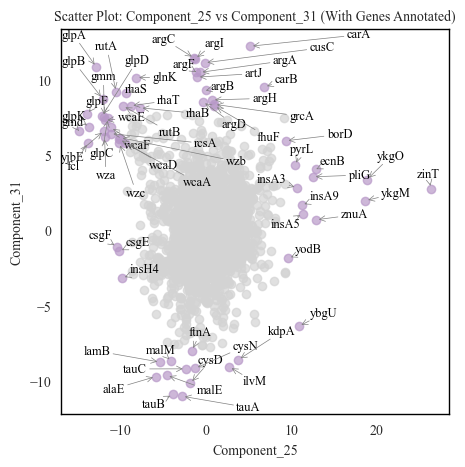

In [349]:
scatter_plot_with_outliers(components_pca, 'Component_25', 'Component_31', threshold=3.7)

## Scatter plot for top components

In [27]:
from adjustText import adjust_text

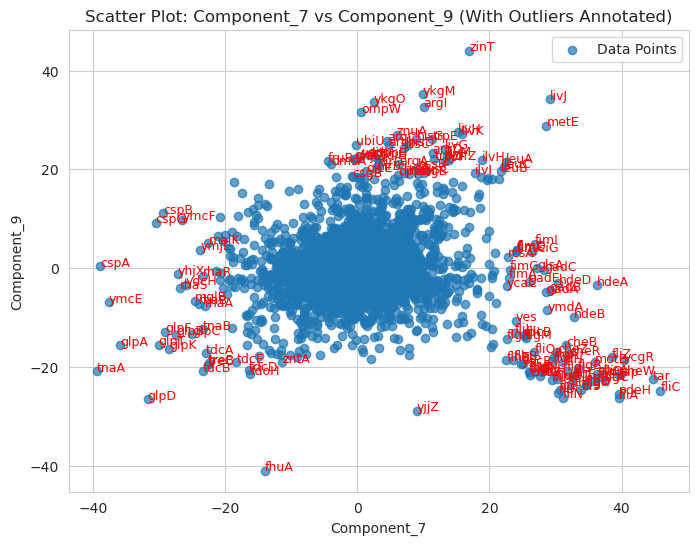

In [38]:
threshold = 3

# Compute the mean and standard deviation for each component
mean_7 = components_pca['Component_7'].mean()
std_7 = components_pca['Component_7'].std()

mean_9 = components_pca['Component_9'].mean()
std_9 = components_pca['Component_9'].std()

# Identify outliers in both Component_7 and Component_9
outliers = components_pca[
    (components_pca['Component_7'] > mean_7 + threshold * std_7) | 
    (components_pca['Component_7'] < mean_7 - threshold * std_7) |
    (components_pca['Component_9'] > mean_9 + threshold * std_9) |
    (components_pca['Component_9'] < mean_9 - threshold * std_9)
]

# Scatter plot of Component_7 vs Component_9
plt.figure(figsize=(8, 6))
plt.scatter(components_pca['Component_7'], components_pca['Component_9'], alpha=0.7, label="Data Points")

# Annotate outliers
for idx, row in outliers.iterrows():
    plt.text(row['Component_7'], row['Component_9'], str(idx), fontsize=9, color='red')

# Plot formatting
plt.title('Scatter Plot: Component_7 vs Component_9 (With Outliers Annotated)')
plt.xlabel('Component_7')
plt.ylabel('Component_9')
plt.grid(True)
plt.legend()
plt.show()

In [139]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_outliers(df, col_x, col_y, threshold=4.7, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    annotates outliers based on a threshold, and adjusts text to avoid overlap.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    threshold (float): The number of standard deviations away from the mean to consider a point as an outlier.
    save_as (str): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Compute the mean and standard deviation for each component
    mean_x = df[col_x].mean()
    std_x = df[col_x].std()

    mean_y = df[col_y].mean()
    std_y = df[col_y].std()

    # Identify outliers in both col_x and col_y
    outliers = df[
        (df[col_x] > mean_x + threshold * std_x) | 
        (df[col_x] < mean_x - threshold * std_x) |
        (df[col_y] > mean_y + threshold * std_y) |
        (df[col_y] < mean_y - threshold * std_y)
    ]
    
    # Non-outliers
    non_outliers = df.drop(outliers.index)

    # Scatter plot of col_x vs col_y
    plt.figure(figsize=(5, 5))

    # Plot non-outliers in light grey
    plt.scatter(non_outliers[col_x], non_outliers[col_y], alpha=0.7, label="Non-Outliers", color='lightgrey')

    # Plot outliers in #b899c8 color
    plt.scatter(outliers[col_x], outliers[col_y], alpha=0.7, label="Outliers", color='#b899c8')

    # Annotate outliers
    texts = []
    for idx, row in outliers.iterrows():
        # Add text slightly offset from the point to avoid overlap
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))

    # Adjust text positions to prevent overlap with points and other text
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5),  # Ensure distance between points and text
                expand_text=(1.5, 1.5))    # Ensure distance between text elements

    # Set font for plot title, labels, and tick labels
    plt.title(f'Scatter Plot: {col_x} vs {col_y} (With Genes Annotated)', fontproperties=font_prop)
    plt.xlabel(col_x, fontproperties=font_prop)
    plt.ylabel(col_y, fontproperties=font_prop)

    # Customize tick labels to use the custom font
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Plot formatting
    # plt.legend(False)

    # Save plot as SVG if save_as path is provided
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')

    # Show the plot if save_as is not provided
    else:
        plt.show()


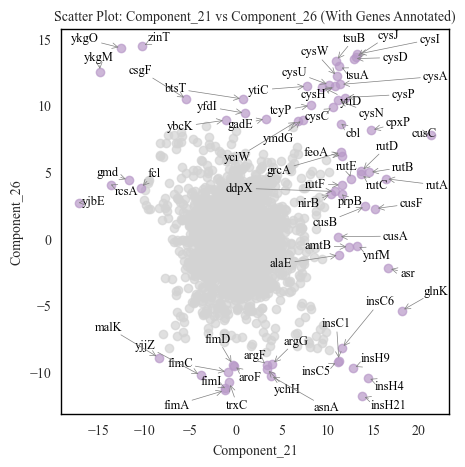

In [167]:
scatter_plot_with_outliers(components_pca, 'Component_21', 'Component_26', threshold=3.7)

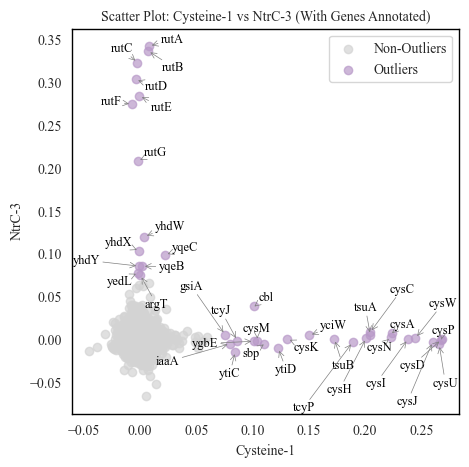

In [70]:
scatter_plot_with_outliers(components_ica, 'Cysteine-1', 'NtrC-3', threshold=4.4)

In [157]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, list1, list2, list3=None, x_label=None, y_label=None, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on two or three input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Separate the data into groups: list1, list2, list3 (if provided), and others
    list1_points = df.loc[list1]
    list2_points = df.loc[list2]
    if list3 is not None:
        list3_points = df.loc[list3]
        other_points = df.drop(list1 + list2 + list3)
    else:
        other_points = df.drop(list1 + list2)

    # Scatter plot of col_x vs col_y
    plt.figure(figsize=(4.5, 4.5))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points in list1 with color #f6cd82
    plt.scatter(list1_points[col_x], list1_points[col_y], alpha=0.7, color='#f6cd82')

    # Plot points in list2 with color #b899c8
    plt.scatter(list2_points[col_x], list2_points[col_y], alpha=0.7, color='#b899c8')

    # If list3 is provided, plot points in list3 with color #94c47d
    if list3 is not None:
        plt.scatter(list3_points[col_x], list3_points[col_y], alpha=0.7, color='#94c47d')

    # Annotate points in list1, list2, and list3 (if provided)
    texts = []
    for idx, row in list1_points.iterrows():
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))
    for idx, row in list2_points.iterrows():
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))
    if list3 is not None:
        for idx, row in list3_points.iterrows():
            texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                  color='black', fontproperties=font_prop))

    # Adjust text positions to prevent overlap with points and other text
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5),  # Ensure distance between points and text
                expand_text=(1.5, 1.5))    # Ensure distance between text elements

    # Set font for plot title, labels, and tick labels
    plt.title('', fontproperties=font_prop)

    # Set x and y labels, defaulting to col_x and col_y if no custom labels are provided
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels to use the custom font
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save plot as SVG if save_as path is provided
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')

    # Show the plot if save_as is not provided
    else:
        plt.show()


In [158]:
list1 = ['rutA', 'rutB', 'rutC', 'rutD', 'rutF', 'rutE', 'rutG', 'yhdX', 'yhdW', 'yhdY']

In [159]:
list2 = ['cysP', 'cysW', 'cysU', 'cysD', 'cysJ', 'cysI', 'cysN', 'cysA', 'cysC', 'cysH', 'tcyP', 'cysK', 'yciW', 'tsuB', 'tsuA']

In [160]:
list3 = ['ykgM', 'ykgO', 'zinT', 'fimC', 'fimI', 'fimA', 'trxC', 'yjjZ', 'yjbE', 'rcsA', 'gmd', 'asnA', 'ychH', 'insC1', 'insC5', 'insC6', 'insH9', 'insH4', 'insH21',
        'glnK', 'fimD', 'fimG', 'fimF', 'fimH']

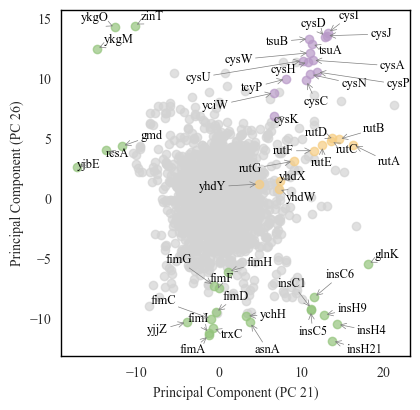

In [161]:
scatter_plot_with_annotations(components_pca, 'Component_21', 'Component_26', list1, list2, list3, 
                              x_label='Principal Component (PC 21)', y_label='Principal Component (PC 26)', save_as='High_MI_PCA_scatter_plot.svg')

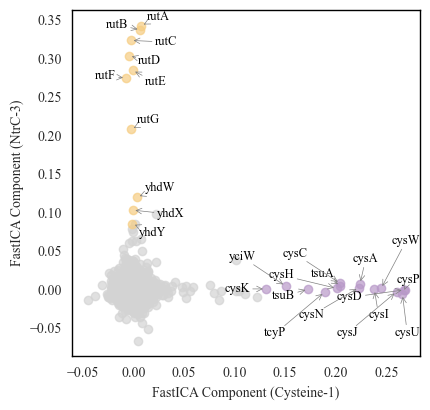

In [162]:
scatter_plot_with_annotations(components_ica, 'Cysteine-1', 'NtrC-3', list1, list2,
                              x_label='FastICA Component (Cysteine-1)', y_label='FastICA Component (NtrC-3)', save_as='Cysteine_1_NtrC_3_scatter_plot.svg')

In [163]:
list4 = ['fimC', 'fimI', 'fimA', 'fimD', 'fimG', 'fimF', 'fimH']

In [164]:
list5 = ['insC1', 'insC5', 'insC6', 'insH9', 'insH4', 'insH21']

In [165]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, list1, list2, list3=None, x_label=None, y_label=None, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on two or three input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Separate the data into groups: list1, list2, list3 (if provided), and others
    list1_points = df.loc[list1]
    list2_points = df.loc[list2]
    if list3 is not None:
        list3_points = df.loc[list3]
        other_points = df.drop(list1 + list2 + list3)
    else:
        other_points = df.drop(list1 + list2)

    # Scatter plot of col_x vs col_y
    plt.figure(figsize=(4.5, 4.5))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points in list1 with color #f6cd82
    plt.scatter(list1_points[col_x], list1_points[col_y], alpha=0.7, color='#94c47d')

    # Plot points in list2 with color #b899c8
    plt.scatter(list2_points[col_x], list2_points[col_y], alpha=0.7, color='#94c47d')

    # If list3 is provided, plot points in list3 with color #94c47d
    if list3 is not None:
        plt.scatter(list3_points[col_x], list3_points[col_y], alpha=0.7, color='#94c47d')

    # Annotate points in list1, list2, and list3 (if provided)
    texts = []
    for idx, row in list1_points.iterrows():
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))
    for idx, row in list2_points.iterrows():
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))
    if list3 is not None:
        for idx, row in list3_points.iterrows():
            texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                  color='black', fontproperties=font_prop))

    # Adjust text positions to prevent overlap with points and other text
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5),  # Ensure distance between points and text
                expand_text=(1.5, 1.5))    # Ensure distance between text elements

    # Set font for plot title, labels, and tick labels
    plt.title('', fontproperties=font_prop)

    # Set x and y labels, defaulting to col_x and col_y if no custom labels are provided
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels to use the custom font
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save plot as SVG if save_as path is provided
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')

    # Show the plot if save_as is not provided
    else:
        plt.show()


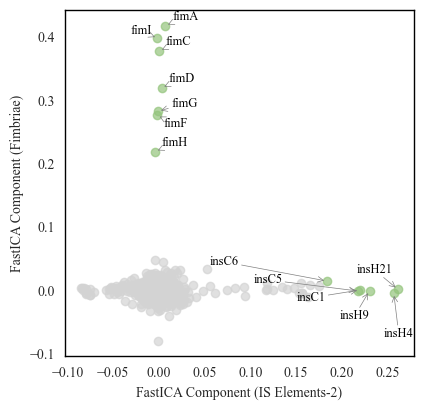

In [166]:
scatter_plot_with_annotations(components_ica, 'IS Elements-2', 'Fimbriae', list4, list5,
                              x_label='FastICA Component (IS Elements-2)', y_label='FastICA Component (Fimbriae)', save_as='IS_2_Fimbriae_scatter_plot.svg')

## Color Update

In [332]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#f6cd82', '#b899c8', '#94c47d', '#ff7f0e', '#d62728', '#1f77b4']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(5, 5))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


In [333]:
list1 = ['rutA', 'rutB', 'rutC', 'rutD', 'rutF', 'rutE', 'rutG', 'yhdX', 'yhdW', 'yhdY']

In [334]:
list2 = ['cysP', 'cysW', 'cysU', 'cysD', 'cysJ', 'cysI', 'cysN', 'cysA', 'cysC', 'cysH', 'tcyP', 'cysK', 'yciW', 'tsuB', 'tsuA']

In [335]:
list3 = ['ykgM', 'ykgO', 'zinT']

In [336]:
list4 = ['yjbE', 'rcsA', 'gmd', 'fcl', 'wcaF', 'wza', 'wcaE', 'gmm', 'wzb', 'wcaA', 'wzc']

In [337]:
list5 = ['insC1', 'insC5', 'insC6', 'insH9', 'insH4', 'insH21', 'insD5', 'insD1', 'insA6', 'insA4']

In [338]:
list6 = ['fimC', 'fimI', 'fimA', 'fimD', 'fimG', 'fimF', 'fimH']

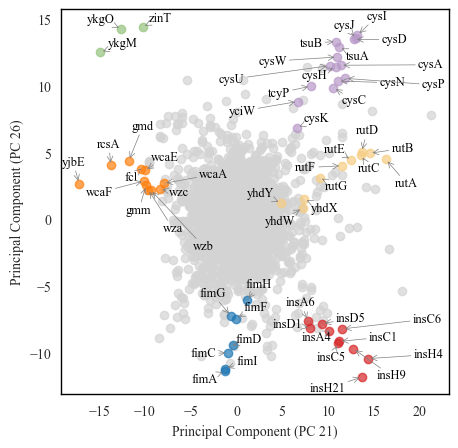

In [339]:
scatter_plot_with_annotations(components_pca, 'Component_21', 'Component_26', list1, list2, list3, list4, list5, list6,
                              x_label='Principal Component (PC 21)', y_label='Principal Component (PC 26)', save_as='High_MI_PCA_scatter_plot.svg')

In [340]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#f6cd82', '#b899c8', '#94c47d', '#ff7f0e', '#d62728', '#1f77b4']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks([-0.1, 0.0, 0.1, 0.2, 0.3], fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


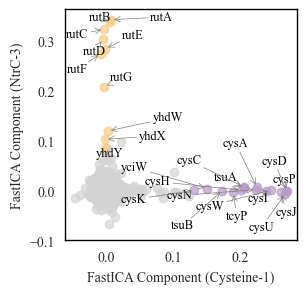

In [341]:
scatter_plot_with_annotations(components_ica, 'Cysteine-1', 'NtrC-3', list1, list2,
                              x_label='FastICA Component (Cysteine-1)', y_label='FastICA Component (NtrC-3)', save_as='Cysteine_1_NtrC_3_scatter_plot.svg')

In [344]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#d62728', '#1f77b4', '#94c47d', '#ff7f0e', '#b899c8', '#f6cd82']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


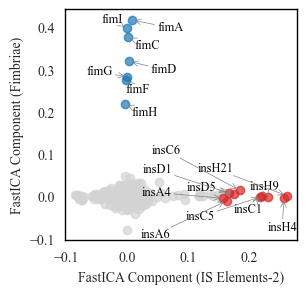

In [345]:
scatter_plot_with_annotations(components_ica, 'IS Elements-2', 'Fimbriae', list5, list6,
                              x_label='FastICA Component (IS Elements-2)', y_label='FastICA Component (Fimbriae)', save_as='IS_2_Fimbriae_scatter_plot.svg')

In [342]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#94c47d', '#ff7f0e', '#d62728', '#1f77b4', '#b899c8', '#f6cd82']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


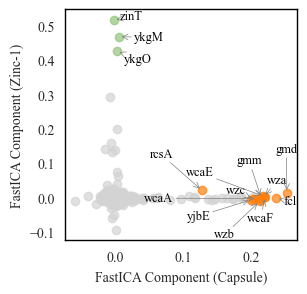

In [343]:
scatter_plot_with_annotations(components_ica, 'Capsule', 'Zinc-1', list3, list4,
                              x_label='FastICA Component (Capsule)', y_label='FastICA Component (Zinc-1)', save_as='Capsule_Zinc_1_scatter_plot.svg')